In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Packages

In [ ]:
import time
import numpy as np
import pandas as pd
import os
import cv2
import random
import pickle
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from google.colab.patches import cv2_imshow
import statistics
import scipy.stats
from scipy.stats import mode
import math

##Load Dataset

In [ ]:
# Define labels of the classes

CLASSES = ["healthy","brownspot", "hispa", "leafblast"]

In [ ]:
folder = "/content/drive/MyDrive/revisi/1200/dataset"
img_array = []
class_num_list1 = []
for c in CLASSES:
            class_num = CLASSES.index(c)
            path = os.path.join(folder,c) # create path to ill subfolders
            for img in tqdm(os.listdir(path)):  # iterate over each image per folder
                try:
                    img = cv2.imread(os.path.join(path,img))  # read image into a list
                    img_array.append(img)
                    class_num_list1.append(class_num) # save a list of the subclass numbers; 0=healthy, 1 = brownspot, 2 = hispa, 3 = leafblast
                except Exception as e:
                    print("error")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
folder_aug = "/content/drive/MyDrive/revisi/1200/augmented images"
aug_array = []
class_num_list2 = []
#subcls_num_list1 = ["None"]*500   # fill the list with 800 "None's" first to represent "healthy" samples

for c in CLASSES:
            class_num = CLASSES.index(c)
            path = os.path.join(folder_aug,c) # create path to aug folders
            for img in tqdm(os.listdir(path)):  # iterate over each image per folder_aug
                try:
                    img = cv2.imread(os.path.join(path,img))  # read image into a list
                    aug_array.append(img)
                    class_num_list2.append(class_num) # save a list of the class numbers; 0=healthy, 1 = brownspot, 2 = hispa, 3 = leafblast
                except Exception as e:
                    print("error")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# Combine the original and augmented images into a new list

all_imgs = []

all_imgs = img_array.copy()

for i, img in enumerate(aug_array):
    all_imgs.append(img)

print(len(all_imgs))

2400


In [ ]:
thresh_list = []

for img in tqdm (all_imgs) :
        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(grayscale, 129, 255, cv2.THRESH_BINARY_INV)
        thresh = cv2.dilate(thresh.copy(), None, iterations=5)
        thresh = cv2.erode(thresh.copy(), None, iterations=5)
        b, g, r = cv2.split(img)
        rgba = [b, g, r, thresh]
        dst = cv2.merge(rgba, 4)
        thresh_list.append(dst)

  0%|          | 0/2400 [00:00<?, ?it/s]

## Feature Extraction

###Color Feature Extraction

In [ ]:
# Extract the hue, saturation, and value features from all_imgs
hsv_imgs = []
hsv_features = []
for img in tqdm (thresh_list):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h_mean = np.mean(h)
    s_mean = np.mean(s)
    v_mean = np.mean(v)
    h_mode = mode(h).mode[0]
    s_mode = mode(s).mode[0]
    v_mode = mode(v).mode[0]
    h_variance = np.var(h)
    s_variance = np.var(s)
    v_variance = np.var(v)
    hsv_features.append([h_mean, h_mode, h_variance, s_mean, s_mode, s_variance, v_mean, v_mode, v_variance])
    hsv_imgs.append(hsv)
# Print the length of hsv_features
print(len(hsv_features))

  0%|          | 0/2400 [00:00<?, ?it/s]

2400


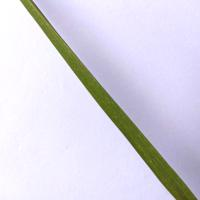

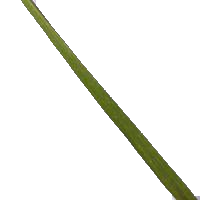

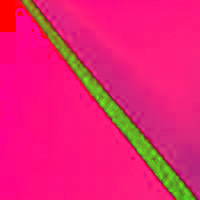

In [ ]:
# Visualize thresholding image#
cv2_imshow(img_array[1])
cv2_imshow(thresh_list[1])
cv2_imshow(hsv_imgs[1])


In [ ]:
pdhsv = pd.DataFrame(hsv_features)
pdhsv

0    1           2          3   4            5           6  \
0     100.943875   90  473.415675  38.382875  11  1843.339782  234.455825   
1     115.220225  140  982.539926  32.877050   3  1650.187783  233.235900   
2     103.983250  108  988.280319  44.020950  17  2335.630511  227.822400   
3     106.953900  112  634.670625  52.753900  41  1250.472085  229.386025   
4     104.270550   96  624.913203  33.537950   5  3201.474610  220.994025   
...          ...  ...         ...        ...  ..          ...         ...   
2395   28.455400   35   54.565111  64.229325   6  7768.536835  196.293125   
2396   22.217400   23   39.960487  40.488075  17  3431.091858  218.482650   
2397   23.752950   21   27.361316  45.743600  10  4027.222359  224.254575   
2398   26.738025   16  104.096844  24.917325   7  2239.223990  221.468075   
2399   30.757775   26   94.755502  30.816975  19  2804.747027  220.982100   

        7            8  
0     255  1558.877249  
1     255  1841.611101  
2     255  2475.939308  
3     255  2260.395810  
4     255  2113.129789  
...   ...          ...  
2395  247  1893.244603  
2396  243  1654.028049  
2397  247  1392.694017  
2398  242  1271.579581  
2399  217  1128.791530  

[2400 rows x 9 columns]

### Texture Feature Extraction

In [ ]:
# Apply Gabor filter to extract features
def build_filters():
    filters = []
    ksize = 5
    for theta in (0, np.pi/6, 3*np.pi / 4):
      for lamda in (math.sqrt(2) / 2, math.sqrt(2) / 2**2, math.sqrt(2) / 2**3, math.sqrt(2) / 2**4, math.sqrt(2) / 2**5, math.sqrt(2) / 2**6, math.sqrt(2) / 2**7 ):
        kern = cv2.getGaborKernel((ksize, ksize), 45.0, theta, lamda, 0.2, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum



In [ ]:
#Number of Filters
filters = build_filters()
print(len(filters))


21


In [ ]:
# Extracting features image with gabor filter
entropy_feature = []
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    for filt in filters:
        extracted = process(img, filt)
        entropy = scipy.stats.entropy(extracted)
        mean_entropy = np.mean(entropy)
        entropy_feature.append(mean_entropy)

# Ubah array energy_feature menjadi 2D
entropy_feature = np.array(entropy_feature).reshape(-1, len(filters))
# Cek hasil
print(entropy_feature.shape)

  0%|          | 0/2400 [00:00<?, ?it/s]

(2400, 21)


In [ ]:
all_gab_img_filter1=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[0])
    all_gab_img_filter1.append(extracted)
all_gab_img_filter2=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[1])
    all_gab_img_filter2.append(extracted)
all_gab_img_filter3=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[2])
    all_gab_img_filter3.append(extracted)
all_gab_img_filter4=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[3])
    all_gab_img_filter4.append(extracted)

all_gab_img_filter5=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[4])
    all_gab_img_filter5.append(extracted)

all_gab_img_filter6=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[5])
    all_gab_img_filter6.append(extracted)

all_gab_img_filter7=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[6])
    all_gab_img_filter7.append(extracted)

all_gab_img_filter8=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[7])
    all_gab_img_filter8.append(extracted)

all_gab_img_filter9=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[8])
    all_gab_img_filter9.append(extracted)

all_gab_img_filter10=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[9])
    all_gab_img_filter10.append(extracted)

all_gab_img_filter11=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[10])
    all_gab_img_filter11.append(extracted)

all_gab_img_filter12=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[11])
    all_gab_img_filter12.append(extracted)

all_gab_img_filter13=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[12])
    all_gab_img_filter13.append(extracted)

all_gab_img_filter14=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[13])
    all_gab_img_filter14.append(extracted)

all_gab_img_filter15=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[14])
    all_gab_img_filter15.append(extracted)

all_gab_img_filter16=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[15])
    all_gab_img_filter16.append(extracted)

all_gab_img_filter17=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[16])
    all_gab_img_filter17.append(extracted)

all_gab_img_filter18=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[17])
    all_gab_img_filter18.append(extracted)

all_gab_img_filter19=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[18])
    all_gab_img_filter19.append(extracted)

all_gab_img_filter20=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[19])
    all_gab_img_filter20.append(extracted)

all_gab_img_filter21=[]
for img in tqdm(thresh_list):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    extracted = process(img, filters[20])
    all_gab_img_filter21.append(extracted)

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
#Menampilkan fitur entropy dengan dataframe (tiap nomer kolom mewakili tiap filter yang telah dibangun sebelumnya )
pdenergy = pd.DataFrame(entropy_feature)
pdenergy

0         1         2         3         4         5         6   \
0     5.281348  5.276793  5.282368  5.282463  5.281796  5.282047  5.282756   
1     5.276138  5.273235  5.278348  5.278446  5.277562  5.278043  5.278763   
2     5.270587  5.269251  5.271675  5.271744  5.271261  5.271605  5.271875   
3     5.274314  5.273684  5.276182  5.276266  5.275582  5.276009  5.276445   
4     5.288875  5.289033  5.289203  5.289212  5.289109  5.289184  5.289187   
...        ...       ...       ...       ...       ...       ...       ...   
2395  5.284661  5.284522  5.284812  5.284824  5.284745  5.284829  5.284787   
2396  5.274750  5.271252  5.274860  5.274950  5.274465  5.274877  5.275140   
2397  5.278368  5.277146  5.278721  5.278778  5.278508  5.278617  5.278853   
2398  5.282205  5.281576  5.282415  5.282468  5.282274  5.282544  5.282509   
2399  5.284747  5.283833  5.284806  5.284848  5.284655  5.284948  5.284860   

            7         8         9   ...        11        12        13  \
0     5.283626  5.298229  5.281846  ...  5.253730  5.291372  5.282790   
1     5.278933  5.298145  5.277935  ...  5.251378  5.285953  5.278899   
2     5.275314  5.298175  5.271460  ...  5.260598  5.283521  5.272162   
3     5.278869  5.297995  5.276126  ...  5.261712  5.285107  5.276789   
4     5.289391  5.297725  5.289202  ...  5.283028  5.289209  5.289076   
...        ...       ...       ...  ...       ...       ...       ...   
2395  5.285475  5.298206  5.284832  ...  5.275862  5.284164  5.284848   
2396  5.279868  5.298289  5.274357  ...  5.237767  5.285630  5.276777   
2397  5.281532  5.298317  5.278612  ...  5.250208  5.286953  5.279058   
2398  5.285081  5.298241  5.282323  ...  5.272804  5.288992  5.282829   
2399  5.287544  5.298162  5.284552  ...  5.267797  5.290698  5.285210   

            14        15        16        17        18        19        20  
0     5.282110  5.282110  5.282110  5.282110  5.282110  5.282110  5.282110  
1     5.278216  5.278216  5.278216  5.278216  5.278216  5.278216  5.278216  
2     5.271519  5.271519  5.271519  5.271519  5.271519  5.271519  5.271519  
3     5.276205  5.276205  5.276205  5.276205  5.276205  5.276205  5.276205  
4     5.289198  5.289198  5.289198  5.289198  5.289198  5.289198  5.289198  
...        ...       ...       ...       ...       ...       ...       ...  
2395  5.284707  5.284707  5.284707  5.284707  5.284707  5.284707  5.284707  
2396  5.274425  5.274425  5.274425  5.274425  5.274425  5.274425  5.274425  
2397  5.278677  5.278677  5.278677  5.278677  5.278677  5.278677  5.278677  
2398  5.282243  5.282243  5.282243  5.282243  5.282243  5.282243  5.282243  
2399  5.284598  5.284598  5.284598  5.284598  5.284598  5.284598  5.284598  

[2400 rows x 21 columns]

Original Image(s)


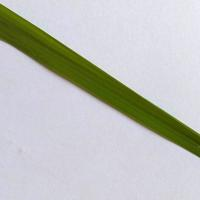

Gambar yang telah di tresholding


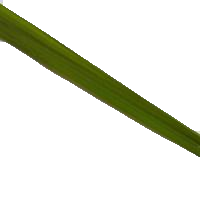

Gambar Filter 1 


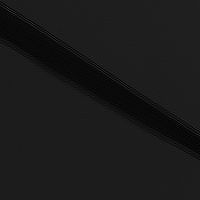

Gambar Filter 2 


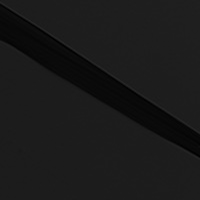

Gambar Filter 3 


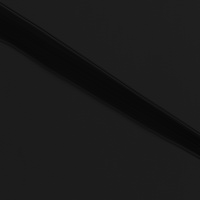

Gambar Filter 4 


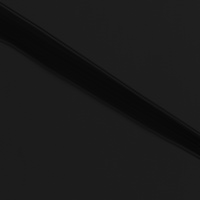

Gambar Filter 5 


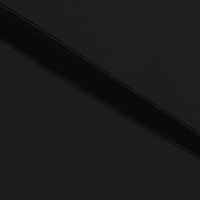

Gambar Filter 6 


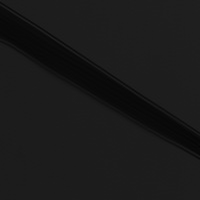

Gambar Filter 7 


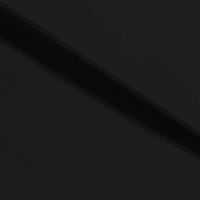

Gambar Filter 8 


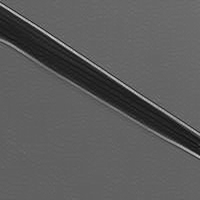

Gambar Filter 9 


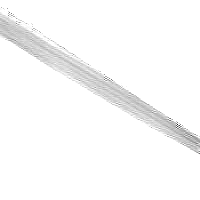

Gambar Filter 10 


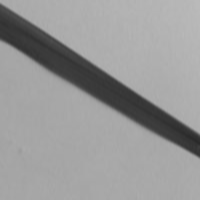

Gambar Filter 11 


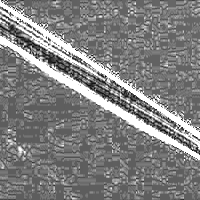

Gambar Filter 12 


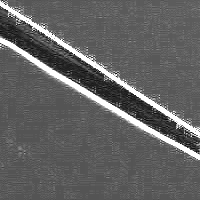

Gambar Filter 13 


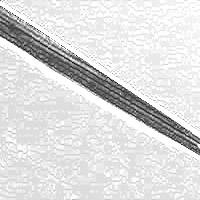

Gambar Filter 14 


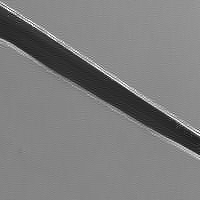

Gambar Filter 15 


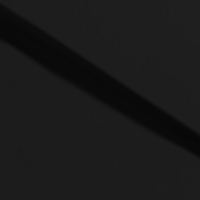

Gambar Filter 16 


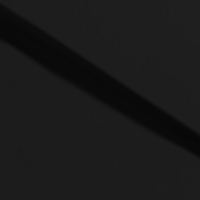

Gambar Filter 17 


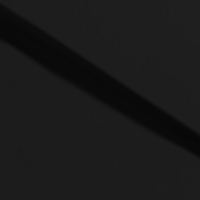

Gambar Filter 18 


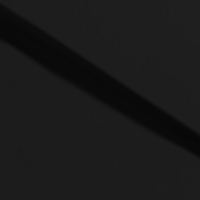

Gambar Filter 19 


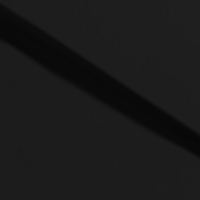

Gambar Filter 20 


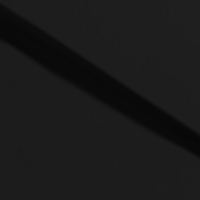

Gambar Filter 21 


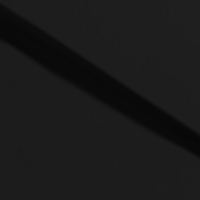

In [ ]:
# Visualize the Gabor features for the hue channel
print("Original Image(s)" )
cv2_imshow(img_array[100])
print("Gambar yang telah di tresholding" )
cv2_imshow(thresh_list[100])
print("Gambar Filter 1 " )
cv2_imshow(all_gab_img_filter1[100])
print("Gambar Filter 2 " )
cv2_imshow(all_gab_img_filter2[100])
print("Gambar Filter 3 " )
cv2_imshow(all_gab_img_filter3[100])
print("Gambar Filter 4 " )
cv2_imshow(all_gab_img_filter4[100])
print("Gambar Filter 5 " )
cv2_imshow(all_gab_img_filter5[100])
print("Gambar Filter 6 " )
cv2_imshow(all_gab_img_filter6[100])
print("Gambar Filter 7 " )
cv2_imshow(all_gab_img_filter7[100])
print("Gambar Filter 8 " )
cv2_imshow(all_gab_img_filter8[100])
print("Gambar Filter 9 " )
cv2_imshow(all_gab_img_filter9[100])
print("Gambar Filter 10 " )
cv2_imshow(all_gab_img_filter10[100])
print("Gambar Filter 11 " )
cv2_imshow(all_gab_img_filter11[100])
print("Gambar Filter 12 " )
cv2_imshow(all_gab_img_filter12[100])
print("Gambar Filter 13 " )
cv2_imshow(all_gab_img_filter13[100])
print("Gambar Filter 14 " )
cv2_imshow(all_gab_img_filter14[100])
print("Gambar Filter 15 " )
cv2_imshow(all_gab_img_filter15[100])
print("Gambar Filter 16 " )
cv2_imshow(all_gab_img_filter16[100])
print("Gambar Filter 17 " )
cv2_imshow(all_gab_img_filter17[100])
print("Gambar Filter 18 " )
cv2_imshow(all_gab_img_filter18[100])
print("Gambar Filter 19 " )
cv2_imshow(all_gab_img_filter19[100])
print("Gambar Filter 20 " )
cv2_imshow(all_gab_img_filter20[100])
print("Gambar Filter 21 " )
cv2_imshow(all_gab_img_filter21[100])

###Combine Features

In [ ]:
combined_features = np.concatenate((hsv_features, entropy_feature), axis=1)

In [ ]:
cfpd = pd.DataFrame(combined_features)
cfpd

0      1           2          3     4            5           6   \
0     100.943875   90.0  473.415675  38.382875  11.0  1843.339782  234.455825   
1     115.220225  140.0  982.539926  32.877050   3.0  1650.187783  233.235900   
2     103.983250  108.0  988.280319  44.020950  17.0  2335.630511  227.822400   
3     106.953900  112.0  634.670625  52.753900  41.0  1250.472085  229.386025   
4     104.270550   96.0  624.913203  33.537950   5.0  3201.474610  220.994025   
...          ...    ...         ...        ...   ...          ...         ...   
2395   28.455400   35.0   54.565111  64.229325   6.0  7768.536835  196.293125   
2396   22.217400   23.0   39.960487  40.488075  17.0  3431.091858  218.482650   
2397   23.752950   21.0   27.361316  45.743600  10.0  4027.222359  224.254575   
2398   26.738025   16.0  104.096844  24.917325   7.0  2239.223990  221.468075   
2399   30.757775   26.0   94.755502  30.816975  19.0  2804.747027  220.982100   

         7            8         9   ...        20        21        22  \
0     255.0  1558.877249  5.281348  ...  5.253730  5.291372  5.282790   
1     255.0  1841.611101  5.276138  ...  5.251378  5.285953  5.278899   
2     255.0  2475.939308  5.270587  ...  5.260598  5.283521  5.272162   
3     255.0  2260.395810  5.274314  ...  5.261712  5.285107  5.276789   
4     255.0  2113.129789  5.288875  ...  5.283028  5.289209  5.289076   
...     ...          ...       ...  ...       ...       ...       ...   
2395  247.0  1893.244603  5.284661  ...  5.275862  5.284164  5.284848   
2396  243.0  1654.028049  5.274750  ...  5.237767  5.285630  5.276777   
2397  247.0  1392.694017  5.278368  ...  5.250208  5.286953  5.279058   
2398  242.0  1271.579581  5.282205  ...  5.272804  5.288992  5.282829   
2399  217.0  1128.791530  5.284747  ...  5.267797  5.290698  5.285210   

            23        24        25        26        27        28        29  
0     5.282110  5.282110  5.282110  5.282110  5.282110  5.282110  5.282110  
1     5.278216  5.278216  5.278216  5.278216  5.278216  5.278216  5.278216  
2     5.271519  5.271519  5.271519  5.271519  5.271519  5.271519  5.271519  
3     5.276205  5.276205  5.276205  5.276205  5.276205  5.276205  5.276205  
4     5.289198  5.289198  5.289198  5.289198  5.289198  5.289198  5.289198  
...        ...       ...       ...       ...       ...       ...       ...  
2395  5.284707  5.284707  5.284707  5.284707  5.284707  5.284707  5.284707  
2396  5.274425  5.274425  5.274425  5.274425  5.274425  5.274425  5.274425  
2397  5.278677  5.278677  5.278677  5.278677  5.278677  5.278677  5.278677  
2398  5.282243  5.282243  5.282243  5.282243  5.282243  5.282243  5.282243  
2399  5.284598  5.284598  5.284598  5.284598  5.284598  5.284598  5.284598  

[2400 rows x 30 columns]

In [ ]:
# Separate the features of augmented images from original images
# to prevent information leakage during splitting

aug_all_features = []
all_features = []

for j in range(len(combined_features)):
    if(j >= 1200):
        aug_all_features.append(combined_features[j])
    else:
        all_features.append(combined_features[j])

print(len(all_features))
print(len(aug_all_features))

1200
1200


## Classification Split 60:40
> ### *Classify into healthy (0), brownspot(1), hispa(2), and leafblast(3) classes*


In [ ]:
# Create partial dataset with features of original images (will add in the augmented set after spliting)
dataset = []

for i, features in enumerate(all_features):
    try:
        img_h = img_array[i]
        dataset.append([features, class_num_list1[i], img_h])
    except Exception as e:
        print("error")

In [ ]:
# Create the augmented images' dataset
aug_dataset = []

for i, aug_features in enumerate(aug_all_features):
    try:
        aug_h = aug_array[i]
        aug_dataset.append([aug_features, class_num_list2[i], aug_h])
    except Exception as e:
        print(e)

In [ ]:
# Split dataset
train_set_before, test_set = train_test_split(dataset, test_size=0.4, shuffle=True, random_state=42)

print('Train set length before data augmentation: ', len(train_set_before))
print('Test set length: ', len(test_set))

Train set length before data augmentation:  720
Test set length:  480


In [ ]:
# Add the augmented dataset into the training set, then shuffle
train_set = []

train_set = train_set_before.copy()

for aug_set in aug_dataset:
    if (len(train_set) < 1920):
        train_set.append(aug_set)

random.shuffle(train_set)
len(train_set)

1920

In [ ]:
# Create training set

X_train = []
y_train = []
h_img1 = []

for features, label, hue in train_set:
    X_train.append(features)
    y_train.append(label)
    h_img1.append(hue)

X_train = np.array(X_train).reshape(len(y_train), -1)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1920, 30)
(1920,)


In [ ]:
# Create testing set

X_test = []
y_test = []
h_img2 = []

for features, label, hue in test_set:
    X_test.append(features)
    y_test.append(label)
    h_img2.append(hue)

X_test = np.array(X_test).reshape(len(y_test), -1)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(480, 30)
(480,)


In [ ]:
pdtest=pd.DataFrame(X_train)
pdtest

0      1            2          3     4            5   \
0     109.994300  117.0   506.820268  47.575675  44.0   853.808723   
1      25.508350   25.0   329.275830  32.510225   6.0  4162.119795   
2      96.835925   93.0   218.606654  40.508975  24.0   803.868669   
3     106.607350  122.0   894.937276  32.532875  17.0  3461.633469   
4     111.361875  123.0   795.577771  46.076075  33.0  1443.125988   
...          ...    ...          ...        ...   ...          ...   
1915  108.644475  115.0  1081.931177  24.481375   6.0  2734.356403   
1916  105.043875    0.0  1179.730350  23.255125   5.0  3093.389736   
1917   95.590600  122.0  1680.094392  59.350325  15.0  7673.756347   
1918  107.266125  120.0  1032.909202  36.055175  14.0  3614.594181   
1919  110.417550  117.0   696.846702  55.216225  44.0  1778.641372   

              6      7            8         9   ...        20        21  \
0     238.859875  253.0  1812.838490  5.280375  ...  5.259691  5.289058   
1     219.083200  241.0  1691.988828  5.285184  ...  5.276806  5.286023   
2     245.469925  255.0  1034.404545  5.285177  ...  5.253604  5.292189   
3     212.275650  207.0  2134.732117  5.265802  ...  5.254445  5.280684   
4     217.208975  255.0  2179.796254  5.273106  ...  5.229728  5.284584   
...          ...    ...          ...       ...  ...       ...       ...   
1915  216.173500  253.0  1804.923648  5.272571  ...  5.236583  5.285753   
1916  217.293875  255.0  2316.368562  5.289470  ...  5.281629  5.288787   
1917  203.817775  232.0  3128.907669  5.248956  ...  5.238089  5.266008   
1918  203.522925  219.0  2007.525074  5.258086  ...  5.223320  5.280660   
1919  229.518100  245.0  2232.426022  5.275667  ...  5.234357  5.286779   

            22        23        24        25        26        27        28  \
0     5.282091  5.280409  5.280409  5.280409  5.280409  5.280409  5.280409   
1     5.285390  5.285419  5.285419  5.285419  5.285419  5.285419  5.285419   
2     5.288471  5.287771  5.287771  5.287771  5.287771  5.287771  5.287771   
3     5.267606  5.265483  5.265483  5.265483  5.265483  5.265483  5.265483   
4     5.275438  5.272312  5.272312  5.272312  5.272312  5.272312  5.272312   
...        ...       ...       ...       ...       ...       ...       ...   
1915  5.274234  5.271955  5.271955  5.271955  5.271955  5.271955  5.271955   
1916  5.289741  5.289878  5.289878  5.289878  5.289878  5.289878  5.289878   
1917  5.250156  5.250076  5.250076  5.250076  5.250076  5.250076  5.250076   
1918  5.266719  5.265100  5.265100  5.265100  5.265100  5.265100  5.265100   
1919  5.278090  5.274801  5.274801  5.274801  5.274801  5.274801  5.274801   

            29  
0     5.280409  
1     5.285419  
2     5.287771  
3     5.265483  
4     5.272312  
...        ...  
1915  5.271955  
1916  5.289878  
1917  5.250076  
1918  5.265100  
1919  5.274801  

[1920 rows x 30 columns]

In [ ]:
# Buat instance MinMaxScaler
scaler = MinMaxScaler()

# Skala data training
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Skala data testing
X_test = scaler.transform(X_test)

In [ ]:
pdtest=pd.DataFrame(X_test)
pdtest

0         1         2         3         4         5         6   \
0    0.848185  0.664740  0.254166  0.372409  0.219512  0.375310  0.641952   
1    0.876114  0.705202  0.300910  0.330415  0.182927  0.426277  0.706324   
2    0.906716  0.693642  0.239841  0.260888  0.134146  0.281602  0.571257   
3    0.146989  0.121387  0.030667  0.400785  0.134146  0.478558  0.577556   
4    0.924932  0.664740  0.167411  0.151796  0.073171  0.187042  0.677709   
..        ...       ...       ...       ...       ...       ...       ...   
475  0.067312  0.208092  0.183956  0.294326  0.073171  0.352513  0.424766   
476  0.870473  0.693642  0.283875  0.327196  0.121951  0.418420  0.574490   
477  0.947154  0.705202  0.179739  0.212271  0.195122  0.197291  0.544974   
478  0.235196  0.433526  0.044541  0.363269  0.024390  0.532205  0.483381   
479  0.915789  0.693642  0.214749  0.222742  0.121951  0.258513  0.569499   

           7         8         9   ...        20        21        22  \
0    1.000000  0.461641  0.605283  ...  0.462863  0.719475  0.652070   
1    0.803571  0.431356  0.654287  ...  0.535481  0.734973  0.676518   
2    0.758929  0.317057  0.716612  ...  0.588386  0.733057  0.727975   
3    0.687500  0.291817  0.744859  ...  0.645364  0.750172  0.748624   
4    1.000000  0.208892  0.811430  ...  0.477764  0.868598  0.851198   
..        ...       ...       ...  ...       ...       ...       ...   
475  0.598214  0.280013  0.687061  ...  0.510262  0.631621  0.698109   
476  0.910714  0.407195  0.630784  ...  0.400437  0.668583  0.656800   
477  0.741071  0.134154  0.901359  ...  0.830396  0.850086  0.903335   
478  0.607143  0.318679  0.959073  ...  0.922771  0.904025  0.960161   
479  0.937500  0.305967  0.627634  ...  0.393583  0.765906  0.723012   

           23        24        25        26        27        28        29  
0    0.649421  0.649421  0.649421  0.649421  0.649421  0.649421  0.649421  
1    0.664516  0.664516  0.664516  0.664516  0.664516  0.664516  0.664516  
2    0.724716  0.724716  0.724716  0.724716  0.724716  0.724716  0.724716  
3    0.748861  0.748861  0.748861  0.748861  0.748861  0.748861  0.748861  
4    0.846877  0.846877  0.846877  0.846877  0.846877  0.846877  0.846877  
..        ...       ...       ...       ...       ...       ...       ...  
475  0.699410  0.699410  0.699410  0.699410  0.699410  0.699410  0.699410  
476  0.648954  0.648954  0.648954  0.648954  0.648954  0.648954  0.648954  
477  0.904756  0.904756  0.904756  0.904756  0.904756  0.904756  0.904756  
478  0.963010  0.963010  0.963010  0.963010  0.963010  0.963010  0.963010  
479  0.743846  0.743846  0.743846  0.743846  0.743846  0.743846  0.743846  

[480 rows x 30 columns]

### Train Model

#### Training Performance

In [ ]:
# Define the parameter grid
param_grid = {'kernel': ['poly'], 'C': [0.1, 0.5, 0.7, 1, 2, 3, 5, 7, 10]}

# Create the SVM model
svm = SVC()

# Create the grid search object
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)



reportdf = pd.DataFrame(grid_search.cv_results_)



In [ ]:
# Print the results
print(reportdf[['mean_test_score', 'params']])

   mean_test_score                        params
0         0.743229  {'C': 0.1, 'kernel': 'poly'}
1         0.754688  {'C': 0.5, 'kernel': 'poly'}
2         0.758333  {'C': 0.7, 'kernel': 'poly'}
3         0.758854    {'C': 1, 'kernel': 'poly'}
4         0.767188    {'C': 2, 'kernel': 'poly'}
5         0.765625    {'C': 3, 'kernel': 'poly'}
6         0.773438    {'C': 5, 'kernel': 'poly'}
7         0.777083    {'C': 7, 'kernel': 'poly'}
8         0.774479   {'C': 10, 'kernel': 'poly'}


In [ ]:
# Get the best parameters
best_parameters = grid_search.best_params_

# Create the SVM model with the best parameters
svm = SVC(kernel=best_parameters['kernel'], C=best_parameters['C'])

# Fit the model to the training set
svm.fit(X_train, y_train)

# Predict the labels of the training set
y_pred = svm.predict(X_train)

# Calculate the accuracy of the model.
train_acc = metrics.accuracy_score(y_train, y_pred)*100

# Round the accuracy to 2 decimal digits.
train_acc_rounded = round(train_acc, 2)

print("Classification report for - \n{}:\n{}\n".format(
    svm, metrics.classification_report(y_train, y_pred)))

print("Training accuracy: " + str(train_acc_rounded))


Classification report for - 
SVC(C=7, kernel='poly'):
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       480
           1       0.95      0.99      0.97       471
           2       0.72      0.67      0.69       479
           3       0.94      0.89      0.92       490

    accuracy                           0.82      1920
   macro avg       0.82      0.82      0.82      1920
weighted avg       0.82      0.82      0.82      1920


Training accuracy: 81.98


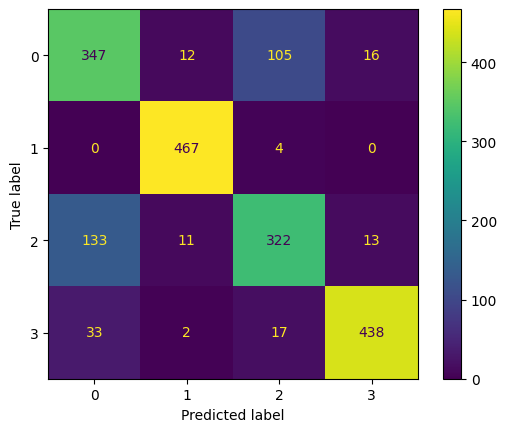

In [ ]:
cm = confusion_matrix(y_train, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

#### Testing Performance

In [ ]:
# Get the test set results
y_pred_test = svm.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(
    svm, metrics.classification_report(y_test, y_pred_test)))

test_acc = metrics.accuracy_score(y_test, y_pred_test)*100

# Round the accuracy to 2 decimal digits.
test_acc_rounded = round(test_acc, 2)

print("Testing accuracy: " + str(test_acc_rounded))

Classification report for - 
SVC(C=7, kernel='poly'):
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       120
           1       0.92      0.95      0.94       129
           2       0.75      0.69      0.72       121
           3       0.89      0.90      0.90       110

    accuracy                           0.82       480
   macro avg       0.82      0.82      0.82       480
weighted avg       0.82      0.82      0.82       480


Testing accuracy: 81.88


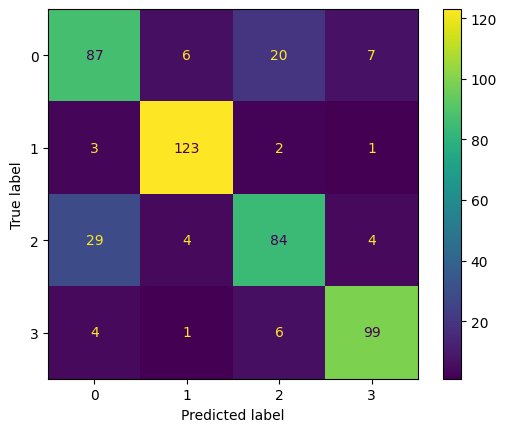

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

cm_display = ConfusionMatrixDisplay(cm).plot()

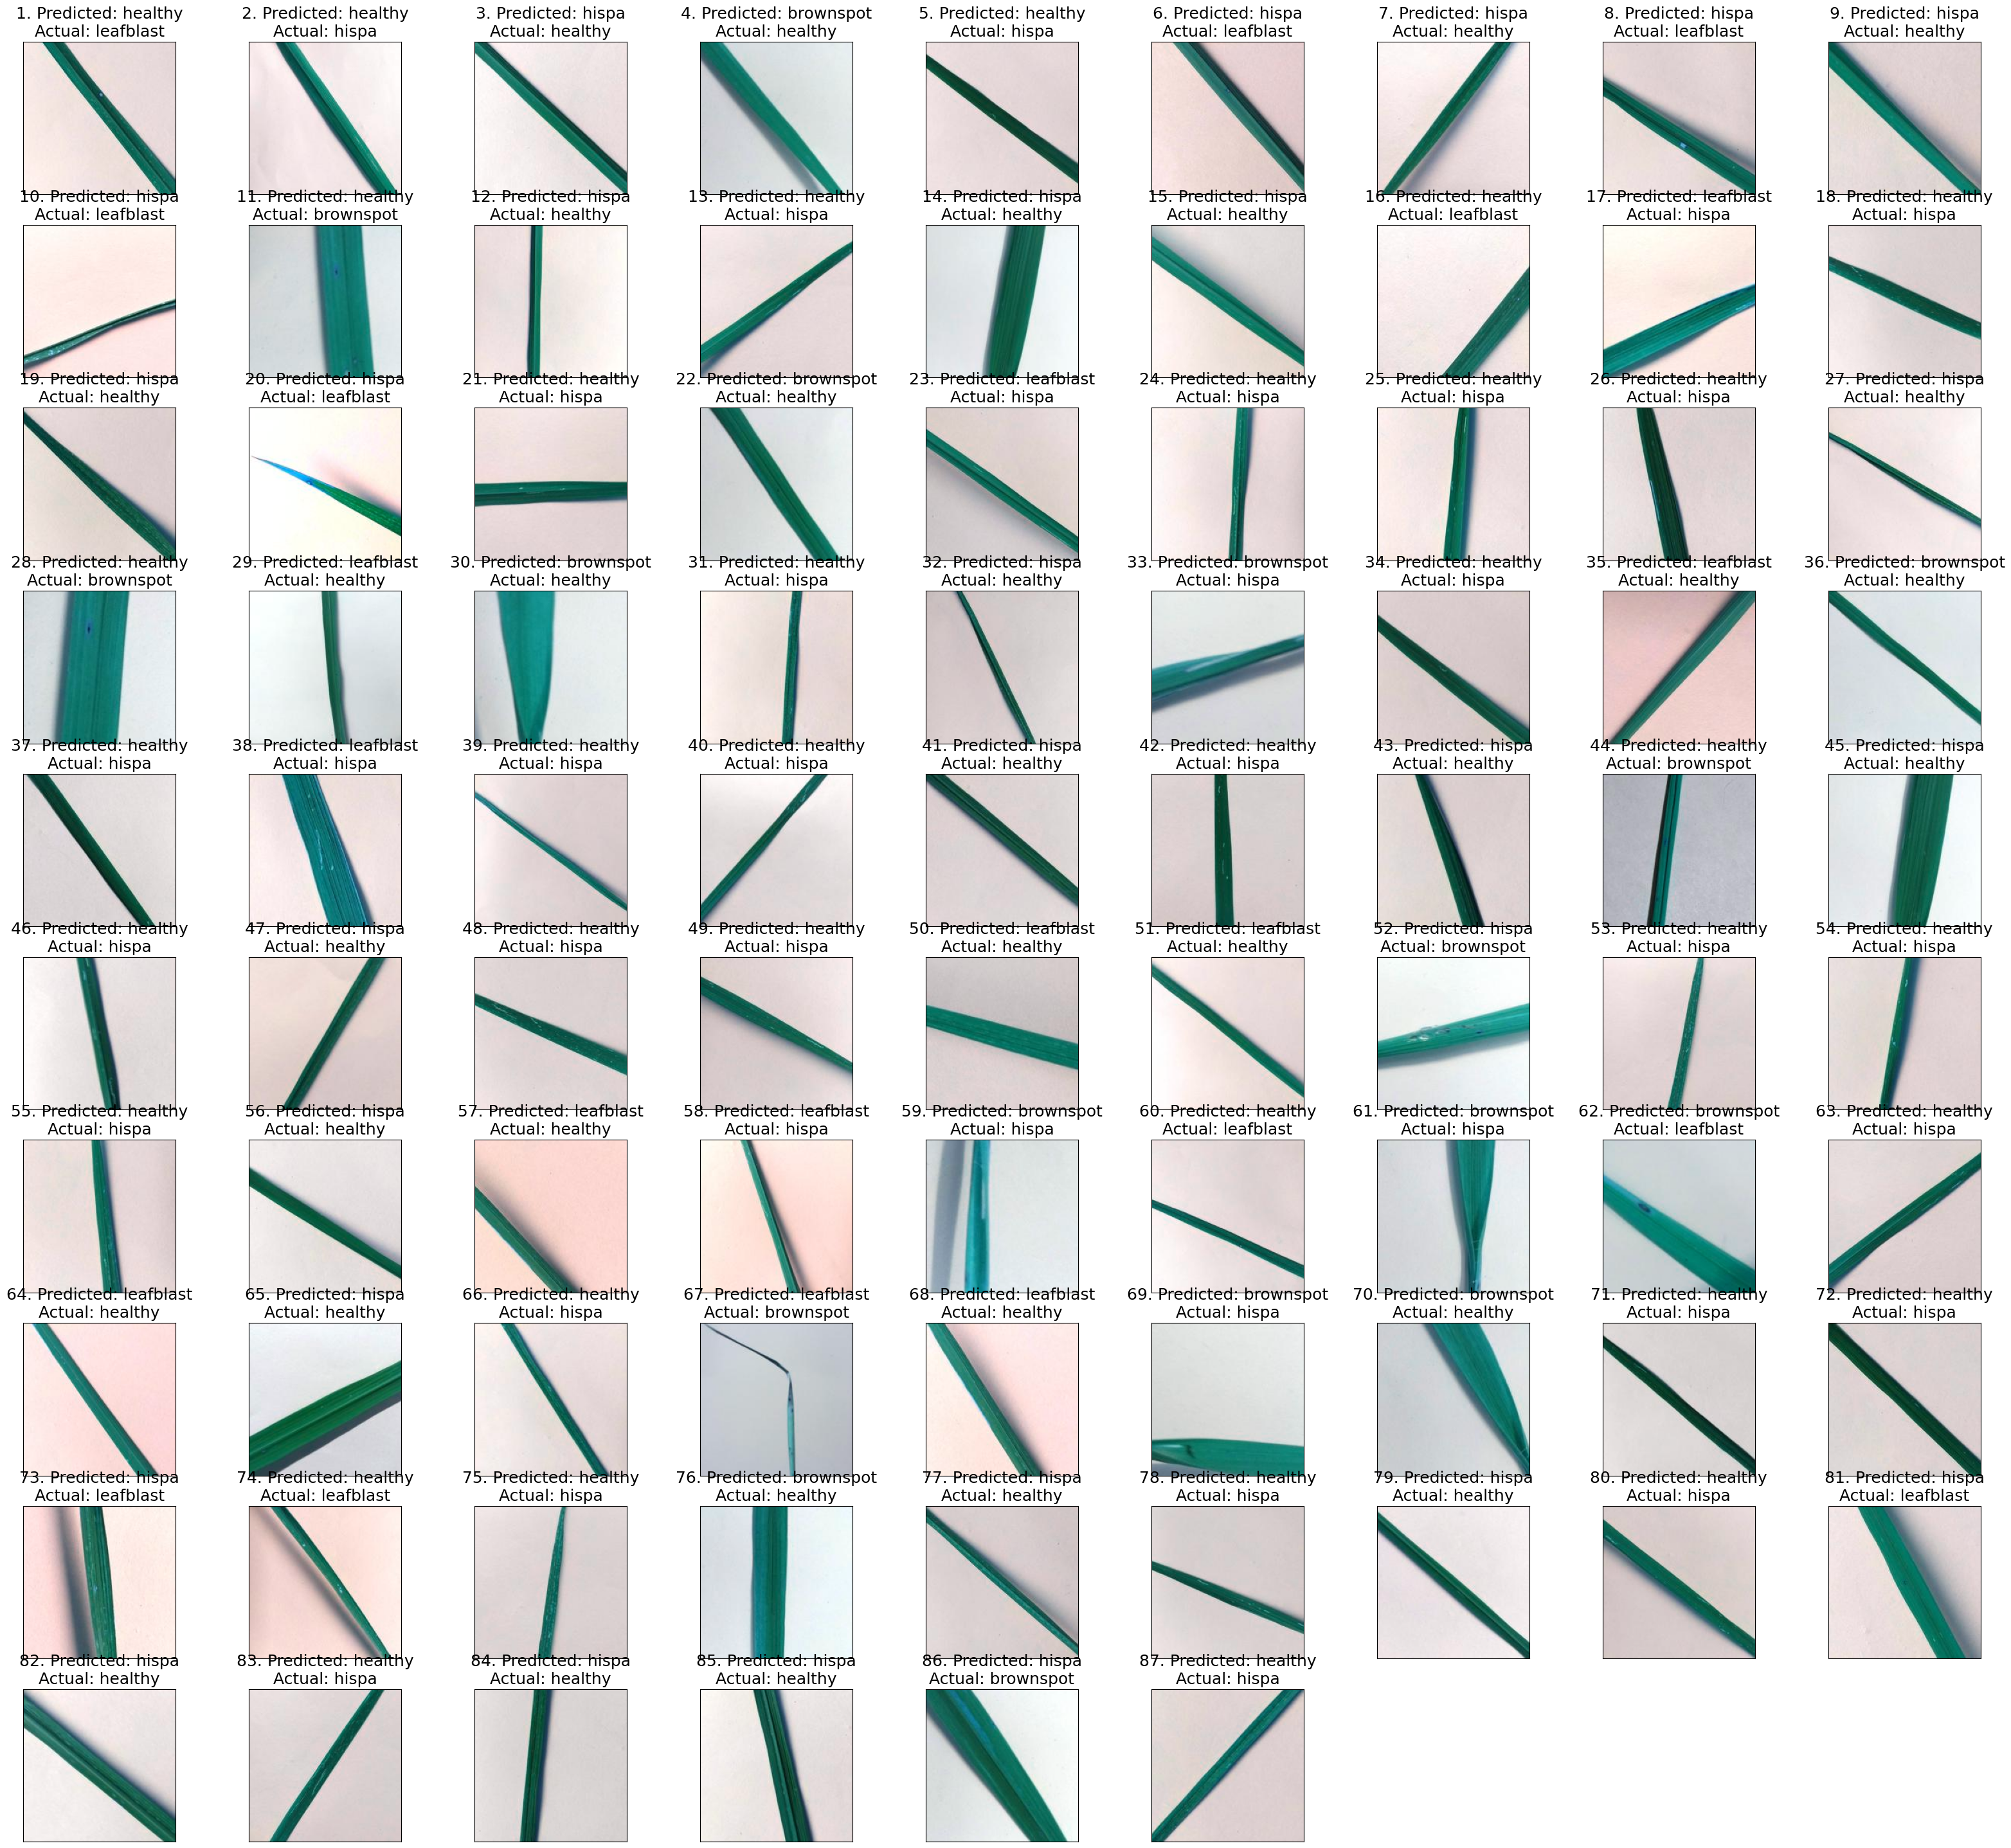

The number of misclassified images: 
87


In [ ]:
# Get wrongly classified samples
def get_wrong_case(pred_result, test_result):

    for i in range(len(pred_result)):
        predicted = pred_result[i]
        actual = test_result[i]
        if(actual != predicted):
            wrong_case.append([i,predicted,actual])

def plot(wrong_case, row, col, hue, labels):

    if (labels == CLASSES):
        fsize = 18
        top = 5
        bottom = 4.3
    else:
        fsize = 20
        top = 3
        bottom = 2.4


    plt.figure(figsize=(40, 40))
    plt.subplots_adjust(top=top, bottom=bottom)

    for i in range(len(wrong_case)):
        plt.subplot(row, col, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        title = str(i+1) + '. Predicted: ' + labels[wrong_case[i][1]] + '\nActual: ' + labels[wrong_case[i][2]]
        plt.title(title, fontdict = {'fontsize' : fsize})
        plt.imshow(hue[wrong_case[i][0]], cmap='gray')

    plt.show()

    print("The number of misclassified images: ")
    print(len(wrong_case))

wrong_case = []
get_wrong_case(y_pred_test, y_test)

# To visualise misclassified samples
col = 9
row = (len(wrong_case) // col) + (len(wrong_case) % 9 > 0)

plot(wrong_case, row, col, h_img2, CLASSES)

# Cross-Validation

In [ ]:
# Cross-validate the model on the training set
scores = cross_val_score(svm, X_train, y_train, cv=10)

# Print the cross-validation scores per line
print("Cross-Validation report \n")
for i, score in enumerate(scores):
    print(f"Accurary on {i + 1}: {round(score, 2)}")

# Calculate the mean cross-validation accuracy
mean_cv_acc = np.mean(scores)

# Print the mean cross-validation accuracy
print(f"\nMean cross-validation accuracy: {round(mean_cv_acc, 2)}")


Cross-Validation report 

Accurary on 1: 0.79
Accurary on 2: 0.81
Accurary on 3: 0.77
Accurary on 4: 0.81
Accurary on 5: 0.73
Accurary on 6: 0.81
Accurary on 7: 0.73
Accurary on 8: 0.75
Accurary on 9: 0.79
Accurary on 10: 0.78

Mean cross-validation accuracy: 0.78
